# Modelo *RMFT* ($\sigma$-$\omega$) con Autointeracción del Campo Escalar

In [ ]:
# Importamos las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 3
from scipy.interpolate import CubicSpline

import scripts.AutointeractuanteEoS as AIEoS

## Ecuacion de Estado del Modelo

### Ecuaciones de la teoría

Habiendo definido los términos de autointeracción del campo escalar en unidades geometrizadas

$$U(\sigma) = \frac{1}{3}b\frac{m}{\hbar}(g_\sigma\sigma)^3+\frac{1}{4}c(g_\sigma\sigma)^4,$$

podemos escribir las ecuaciones de autoconsistencia, energía y presión empleando las variables y parámetros adimensionales $\tilde x_{\sigma} = 1-g_{\sigma}\sigma/m$, $\tilde n = (\hbar^3/m^3)n$, $x = p/m$, $\tilde A_{\sigma} = (g_\sigma/m_\sigma)^2m^2/\hbar$, $\tilde A_{\sigma} = (g_\omega/m_\omega)^2m^2/\hbar$, $\tilde{b}=\hbar^2b$ y $\tilde{c}=\hbar^3c$; y la constante $\lambda = m^4/\hbar^3$

$$ (1-\tilde x_{\sigma}) - \tilde A_{\sigma}\left[\frac{2}{\pi^2} \int_0^{x_F(n)} \frac{\tilde x_{\sigma} x^2 dx}{\sqrt{x^2 + \tilde x_{\sigma}^2}} - \tilde b (1-\tilde x_{\sigma})^2 - \tilde c (1-\tilde x_{\sigma})^3\right] = 0$$
$$ \tilde\rho = \frac{\lambda}{2\rho_0} \left[(1-\tilde x_{\sigma})^2\left(\frac{1}{\tilde A_{\sigma}} + \frac{2}{3}\tilde b(1-\tilde x_{\sigma}) + \frac{1}{2}\tilde c(1-\tilde x_{\sigma})^2\right) + \tilde A_{\omega}^2 \tilde n^2 + \frac{4}{\pi^2} \int_0^{x_F(n)} x^2 \sqrt{x^2 + \tilde x_{\sigma}^2} dx\right]$$
$$ \tilde P = \frac{\lambda}{2\rho_0} \left[-(1-\tilde x_{\sigma})^2\left(\frac{1}{\tilde A_{\sigma}} + \frac{2}{3}\tilde b(1-\tilde x_{\sigma}) + \frac{1}{2}\tilde c(1-\tilde x_{\sigma})^2\right) + \tilde A_{\omega}^2 \tilde n^2 + \frac{4}{3\pi^2} \int_0^{x_F(n)} \frac{x^4}{\sqrt{x^2 + \tilde x_{\sigma}^2}} dx\right]$$

### Ecuación de estado numérica

In [22]:
# Definimos las constantes necesarias en MKS
hbar_MKS = 1.0545718e-34 # J s
c_MKS = 299792458 # m/s
G_MKS = 6.67430e-11 # m^3/kg/s^2
pi = np.pi
m_nuc_MKS = 1.6726219e-27 # kg

# # Definimos las constantes necesarias en unidades geometrizadas
hbar = hbar_MKS * (G_MKS/c_MKS**3) # m^2
m_nuc = m_nuc_MKS * (G_MKS/c_MKS**2) # m
lambda_ = m_nuc**4/hbar**3 # Constante de escala empleada

# Damos valores a las constantes (fijadas con n_sat y (B/A)_sat) (constantes tilde cuadradas)
A_sigma = 330.263 # Walecka: 266.9, 357.4
A_omega = 249.547 # Walecka: 195.7, 273.8
b_ = 1
c_ = 1
params = [A_sigma, A_omega, b_, c_]

# Definimos el rango de densidades para la interpolación de la EoS
densidad_masa_max = 1e18*1e3 # g/cm^3 a kg/m^3
densidad_masa_min = 1e10*1e3 # g/cm^3 a kg/m^3
n_barions = np.logspace(np.log10(densidad_masa_min/m_nuc_MKS), np.log10(densidad_masa_max/m_nuc_MKS), 200)

# Calculamos la EoS (Comentar si se tiene el archivo con los resultados)
rho_P, presiones, energias, n_sirve, presion_cambio = AIEoS.EoS(n_barions, params)
# df = pd.DataFrame({'n': n_sirve[presion_cambio:], 'P': presiones[presion_cambio:], 'E': energias[presion_cambio:]})
# df.to_csv('EoS_tables/SigmaOmegaAuto_rho0_lambda_A_propios.csv', index=False, float_format='%.15e')

# Leemos los resultados de la EoS (Comentar si no se tiene el archivo con los resultados)
# df = pd.read_csv('EoS_tables/SigmaOmegaAuto_rho0_lambda_A_propios.csv')
# n_sirve = df['n'].values
# presiones = df['P'].values
# energias = df['E'].values
# rho_P = CubicSpline(presiones, energias)

## Resultados de la EoS

### Ecuación de autoconsistencia

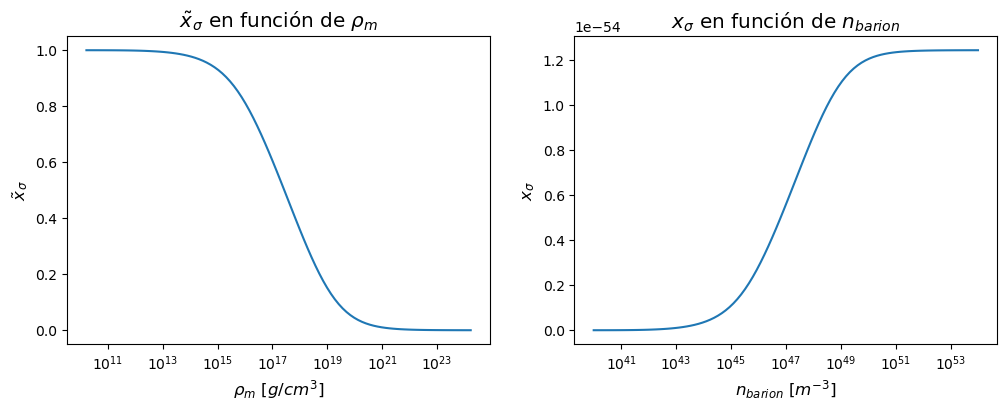

In [ ]:
# Testeamos la solucion_x_sigma
n_prove = np.logspace(40, 54, 100)
x_sigma_prove_tilde = np.zeros(len(n_prove))
x_sigma_prove = np.zeros(len(n_prove))
for i in range(len(n_prove)):
    x_sigma_prove_tilde[i] = AIEoS.sol_x_sigma(n_prove[i], params)
    x_sigma_prove[i] = (1-x_sigma_prove_tilde[i])*m_nuc

# Mostramos los resultados para x_sigma y x_sigma en función de n_barion
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(n_prove*m_nuc_MKS*1e-3, x_sigma_prove_tilde)
ax[0].set_xscale('log')
ax[0].set_xlabel(r'$\rho_m$ $[g/cm^3]$')
ax[0].set_ylabel(r'$\tilde x_{\sigma}$')
ax[0].set_title(r'$\tilde x_{\sigma}$ en función de $\rho_m$')
ax[1].plot(n_prove, x_sigma_prove)
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$n_{barion}$ $[m^{-3}]$')
ax[1].set_ylabel(r'$x_{\sigma}$')
ax[1].set_title(r'$x_{\sigma}$ en función de $n_{barion}$')
plt.show()

### Interpolación y ecuación de estado

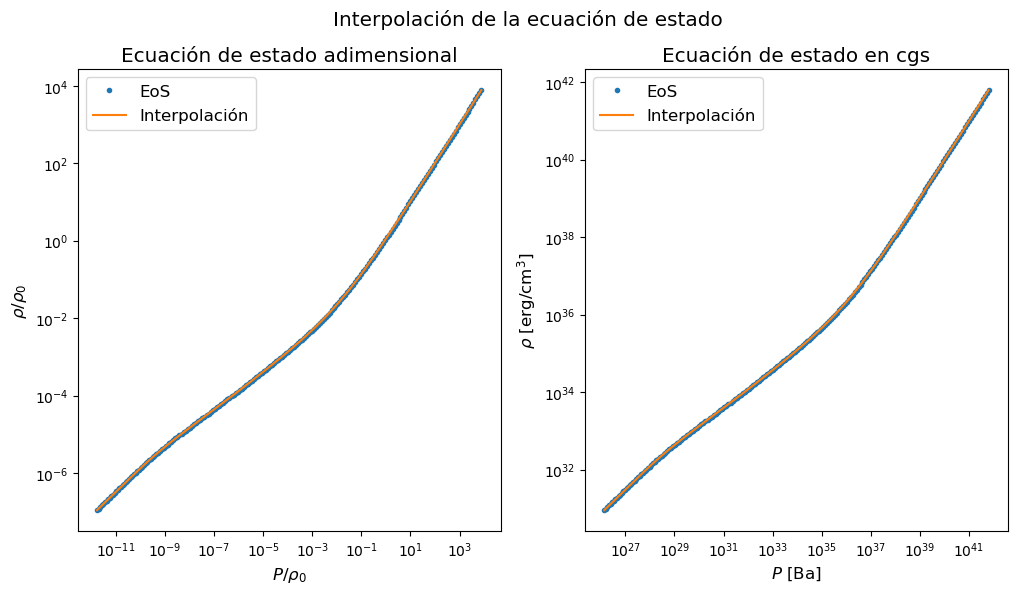

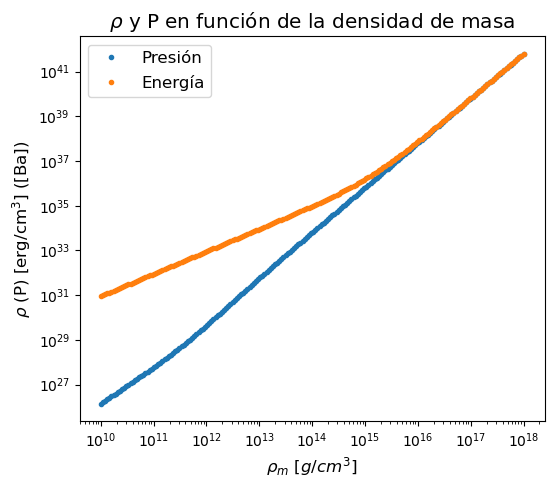

In [23]:
# Graficamos la ecuación de estado rho(P)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

#Adimensional
ax1.loglog(presiones, energias, "o", label='EoS')
ax1.loglog(presiones, rho_P(presiones), label='Interpolación')
ax1.set_xlabel(r'$P/\rho_0$')
ax1.set_ylabel(r'$\rho/\rho_0$')
ax1.set_title('Ecuación de estado adimensional')
ax1.legend()

#cgs
rho_geoToMKS = c_MKS**4/G_MKS # factor de conversión de unidades geométricas a MKS
rho_MKSTocgs = 10 # factor de conversión de unidades MKS a cgs
ax2.loglog(presiones*lambda_/2*rho_geoToMKS*rho_MKSTocgs, energias*lambda_/2*rho_geoToMKS*rho_MKSTocgs, "o", label='EoS')
ax2.loglog(presiones*lambda_/2*rho_geoToMKS*rho_MKSTocgs, rho_P(presiones)*lambda_/2*rho_geoToMKS*rho_MKSTocgs, label='Interpolación')
ax2.set_xlabel(r'$P$ [Ba]')
ax2.set_ylabel(r'$\rho$ [erg/cm$^3$]')
ax2.set_title('Ecuación de estado en cgs')
ax2.legend()

plt.suptitle('Interpolación de la ecuación de estado')
plt.show()

# Graficamos presión y energía en función de n_barion
plt.figure(figsize=(6, 5))
plt.loglog(n_sirve*m_nuc_MKS*1e-3, presiones*lambda_/2*rho_geoToMKS*rho_MKSTocgs, "o", label='Presión')
plt.loglog(n_sirve*m_nuc_MKS*1e-3, energias*lambda_/2*rho_geoToMKS*rho_MKSTocgs, "o", label='Energía')
plt.xlabel(r'$\rho_m$ $[g/cm^3]$')
plt.ylabel(r'$\rho$ (P) [erg/cm$^3$] ([Ba])')
plt.title(r'$\rho$ y P en función de la densidad de masa')
plt.legend()
plt.show()